In [1]:
from hagelslag.evaluation.MetricPlotter import roc_curve, performance_diagram
from holodecml.models import load_model
from functools import partial
from argparse import ArgumentParser
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import traceback
import logging
import signal
import joblib
import scipy
import sys
import yaml
import time
import tqdm
import glob
import gc
import os
import torch
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

import torch
import torch.fft
import torch.nn.functional as F
import torchvision.models as models

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

from holodecml.metrics import DistributedROC
from holodecml.transforms import LoadTransformations
from holodecml.propagation import InferencePropagator
from holodecml.data import save_sparse_csr, load_sparse_csr 

import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

In [2]:
def pad(a, padding = 512, fx = False, fy = False):
    """Return bottom right padding."""
    zeros = np.zeros((padding, padding))
    if not fx and not fy:
        zeros[:a.shape[0], :a.shape[1]] = a
    if fx and not fy:
        zeros[-a.shape[0]:, :a.shape[1]] = a
    if fy and not fx:
        zeros[:a.shape[0], -a.shape[1]:] = a
    else:
        zeros[-a.shape[0]:, -a.shape[1]:] = a
    return zeros

In [3]:
def propagate(prop, image, zp):
    real_zp_im = prop.torch_holo_set(
        torch.from_numpy(image).to(device),
        torch.FloatTensor([zp*1e-6]).to(device)
    ).squeeze(0)
    prop_real = torch.abs(real_zp_im).cpu().numpy()
    return prop_real

def get_particle(prop, h_idx, max_coor = 0, repeat = 0, predicted_particles = None):
    indices = predicted_particles["h"] == h_idx
    predicted_particles = predicted_particles[indices].copy().sort_values("z_p")
    predicted_particles["x_t"] = predicted_particles["x_t"] * (2 * 7209 / 4872) - 7209
    predicted_particles["y_t"] = predicted_particles["y_t"] * (2 * 4806 / 3248) - 4806
    predicted_particles["x_p"] = predicted_particles["x_p"] * (2 * 7209 / 4872) - 7209
    predicted_particles["y_p"] = predicted_particles["y_p"] * (2 * 4806 / 3248) - 4806
    predicted_particles["d_t"] = 2.96 * predicted_particles["d_t"] 
    predicted_particles["d_p"] = 2.96 * predicted_particles["d_p"] 
    
    particle_idx = np.where(prop.h_ds['hid'].values == h_idx+1)
    c = np.isfinite(predicted_particles["x_p"]) & ~np.isfinite(predicted_particles["x_t"])
    
    print("Total examples that need labeled", c.sum())

    x_locations = predicted_particles[c]["x_p"]
    y_locations = predicted_particles[c]["y_p"]
    z_locations = predicted_particles[c]["z_p"]
    d_locations = predicted_particles[c]["d_p"]
        
#     indices = np.where(prop.h_ds["hid"] == h_idx + 1)
#     d_locations = prop.h_ds["d"].values[indices]
#     x_locations = prop.h_ds["x"].values[indices]
#     y_locations = prop.h_ds["y"].values[indices]
#     z_locations = prop.h_ds["z"].values[indices]
    xp = np.digitize(x_locations, 1e6 * prop.x_arr, right=True)
    yp = np.digitize(y_locations, 1e6 * prop.y_arr, right=True)
    zp = z_locations
    dp = d_locations
    
    for (x, y, z, d) in zip(xp, yp, zp, dp):
        yield x, y, z, d

In [4]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

In [8]:
path = "../results/random_sampled/"
config = f'{path}/best.yml'

with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [9]:
table = pd.read_csv(f"{path}/real/prediction_table_0.001.csv")

In [10]:
n_nodes = conf["inference"]["n_nodes"]
n_gpus = conf["inference"]["gpus_per_node"]
threads_per_gpu = conf["inference"]["threads_per_gpu"]
workers = int(n_nodes * n_gpus * threads_per_gpu)
this_worker = 0

save_arrays = conf["inference"]["save_arrays"]

n_bins = conf["data"]["n_bins"]
tile_size = conf["data"]["tile_size"]
step_size = conf["data"]["step_size"]
marker_size = conf["data"]["marker_size"]
transform_mode = "None" if "transform_mode" not in conf[
    "data"] else conf["data"]["transform_mode"]

model_loc = conf["save_loc"]
model_name = conf["model"]["name"]
color_dim = conf["model"]["in_channels"]

batch_size = conf["inference"]["batch_size"]
save_arrays = conf["inference"]["save_arrays"]
save_prob = conf["inference"]["save_probs"]
inference_mode = conf["inference"]["mode"]

if "probability_threshold" in conf["inference"]:
    probability_threshold = conf["inference"]["probability_threshold"]
else:
    probability_threshold = 0.5

verbose = conf["inference"]["verbose"]
data_set = conf["inference"]["data_set"]["path"]
data_set_name = conf["inference"]["data_set"]["name"]

prop_data_loc = os.path.join(model_loc, f"{data_set_name}/propagated")
roc_data_loc = os.path.join(model_loc, f"{data_set_name}/roc")
image_data_loc = os.path.join(model_loc, f"{data_set_name}/images")

for directory in [prop_data_loc, roc_data_loc, image_data_loc]:
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

In [11]:
h_conf = conf["inference"]["data_set"]["holograms"]
if isinstance(h_conf, dict):
    h_min = conf["inference"]["data_set"]["holograms"]["min"]
    h_max = conf["inference"]["data_set"]["holograms"]["max"]
    h_range = range(h_min, h_max)
elif isinstance(h_conf, list):
    h_range = h_conf
elif isinstance(h_conf, int) or isinstance(h_conf, float):
    h_range = [h_conf]
else:
    raise OSError(f"Unidentified h-range settings {h_conf}")

# Load the model
print(
    f"Worker {this_worker}: Loading and moving model to device {device}")
model = load_model(conf["model"]).to(device)

# Load the weights from the training location
checkpoint = torch.load(
    os.path.join(model_loc, "best.pt"),
    map_location=lambda storage, loc: storage
)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel()
                       for p in model.parameters() if p.requires_grad)
print(
    f"Worker {this_worker}: There are {total_params} total model parameters")

# Load the image transformations
if "inference" in conf["transforms"]:
    print(f"Worker {this_worker}: Loading image transformations")
    if "Normalize" in conf["transforms"]["training"]:
        conf["transforms"]["inference"]["Normalize"]["mode"] = conf["transforms"]["training"]["Normalize"]["mode"]
    tile_transforms = LoadTransformations(conf["transforms"]["inference"])
else:
    tile_transforms = None

Worker 0: Loading and moving model to device cuda:0
Worker 0: There are 13601361 total model parameters
Worker 0: Loading image transformations


In [12]:
print(f"Worker {this_worker}: Loading an inference wave-prop generator")

prop = InferencePropagator(
    data_set,
    n_bins=n_bins,
    color_dim=color_dim,
    tile_size=tile_size,
    step_size=step_size,
    marker_size=marker_size,
    transform_mode=transform_mode,
    device=device,
    model=model,
    mode=inference_mode,
    probability_threshold=probability_threshold,
    transforms=tile_transforms
)

# Create a list of z-values to propagate to
z_list = prop.create_z_plane_lst(planes_per_call=1)
z_list = np.array_split(z_list, workers)[this_worker]

Worker 0: Loading an inference wave-prop generator


Total examples that need labeled 53
11 2567 2466 14576.0 13.32
11 599 1528 15080.0 2.96
11 4202 1260 15080.0 29.6
11 2567 2466 15281.6 24.272
11 3608 917 15800.0 19.874285714285715
11 3608 917 16376.0 17.759999999999998
11 605 1527 16448.0 29.6
11 1617 2775 16520.0 25.79428571428571
11 4201 1262 16808.0 21.565714285714286
11 3608 915 17038.4 20.72
11 604 1527 17048.0 24.173333333333332
11 1617 2775 17288.0 22.693333333333335
11 4201 1263 17384.0 26.64
11 1616 2776 18104.0 35.097142857142856
11 4201 1262 18608.0 39.96
11 605 1527 18728.0 40.45333333333333
11 4255 2422 35456.0 20.72
11 4175 2213 37688.0 23.68
11 1905 2545 38024.0 19.733333333333334
11 4175 2214 38744.0 34.04
11 220 3115 45824.0 17.02
11 4579 2008 46436.0 31.08
11 1801 861 49016.0 20.72
11 4757 868 51944.0 20.72
11 2186 2953 57884.0 22.94
11 1704 1993 60224.0 14.8
11 1704 1993 61484.0 38.48
11 1787 2920 62240.0 29.6
11 2965 1928 62564.0 19.98
11 3986 913 66632.0 29.6
11 1606 2280 67064.0 17.759999999999998
11 1604 2281 67

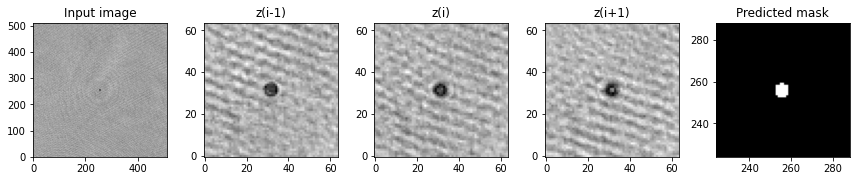

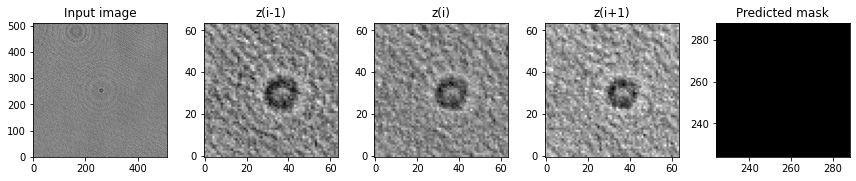

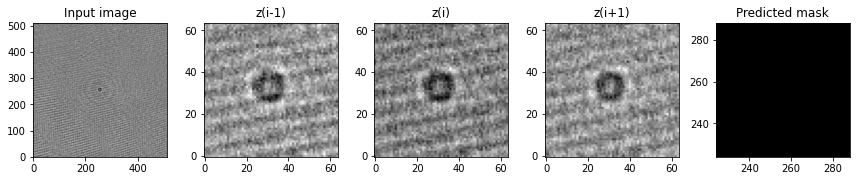

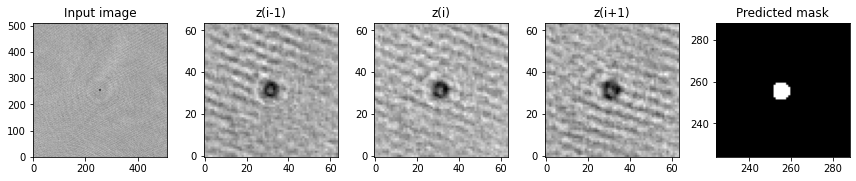

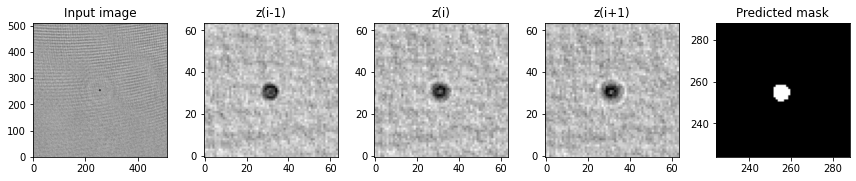

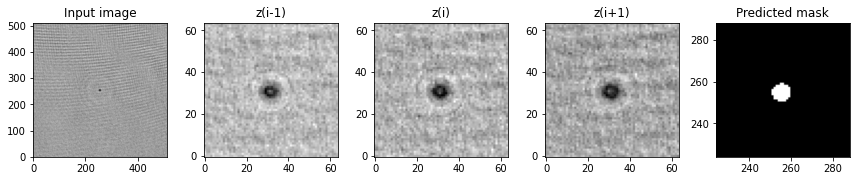

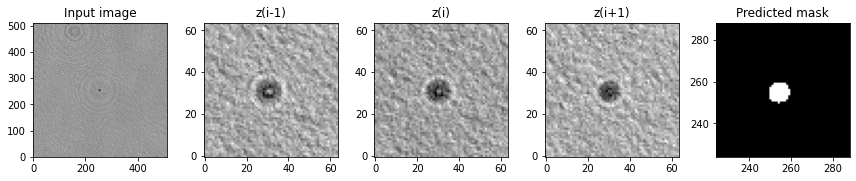

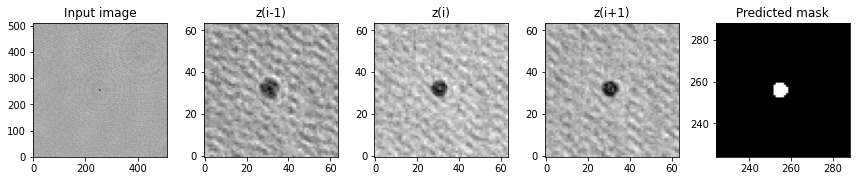

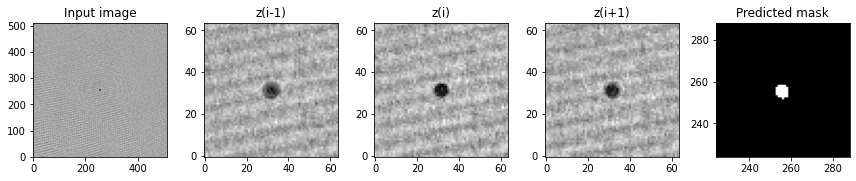

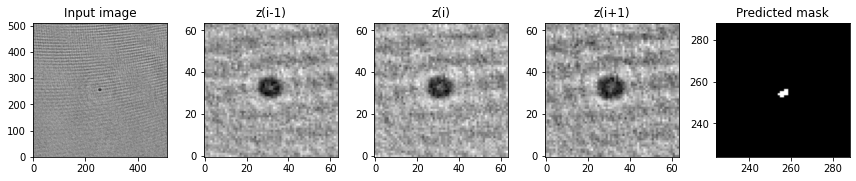

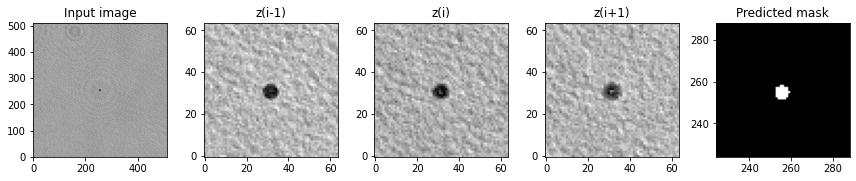

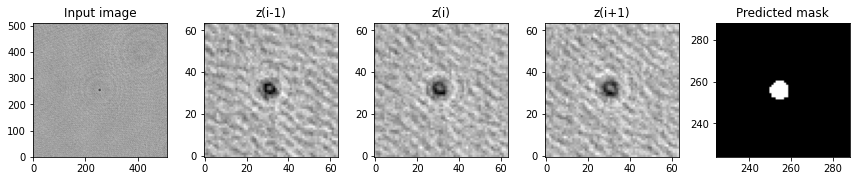

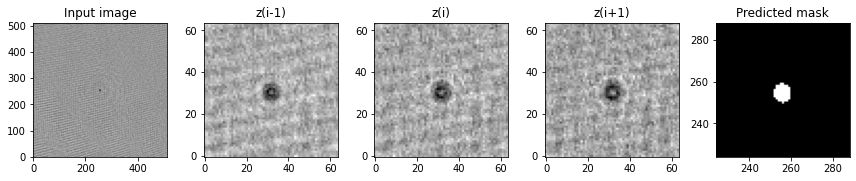

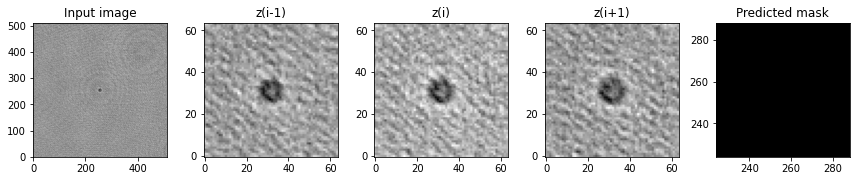

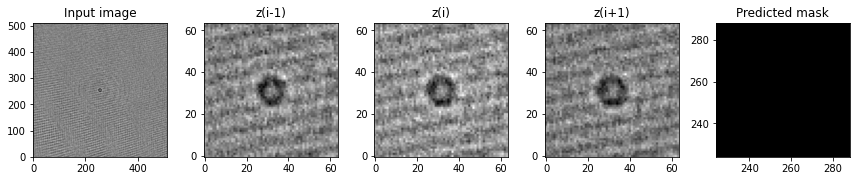

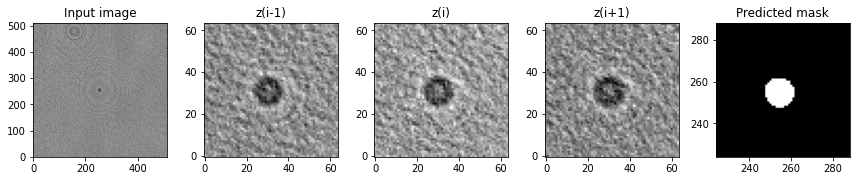

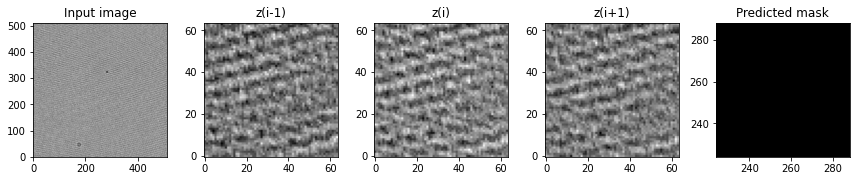

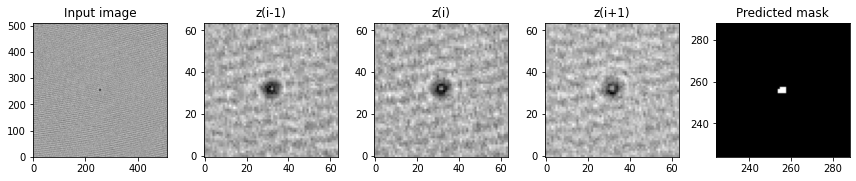

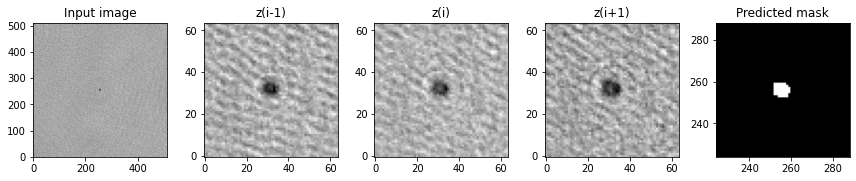

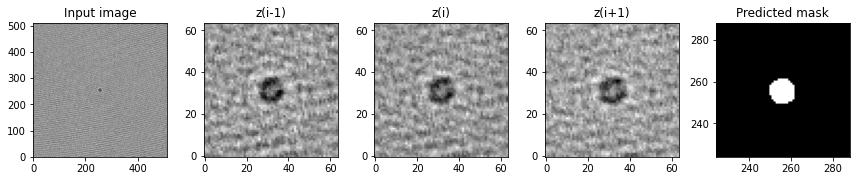

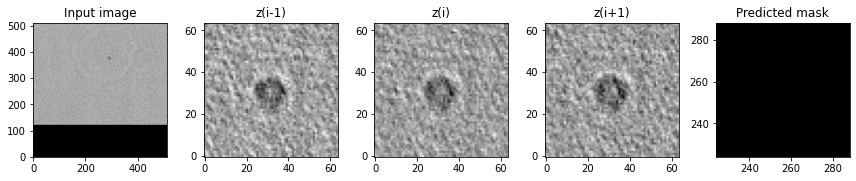

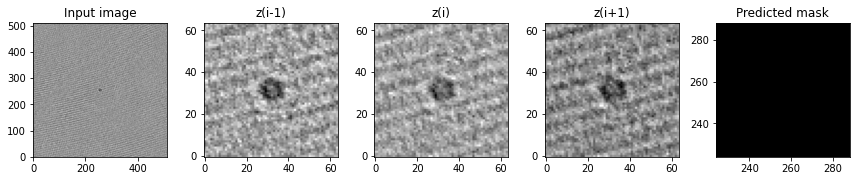

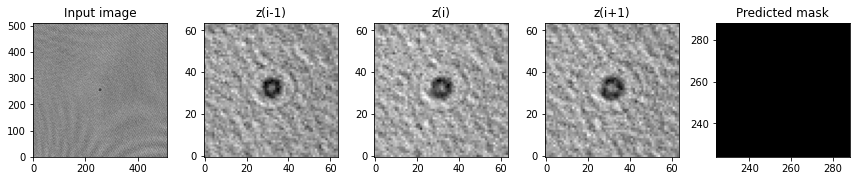

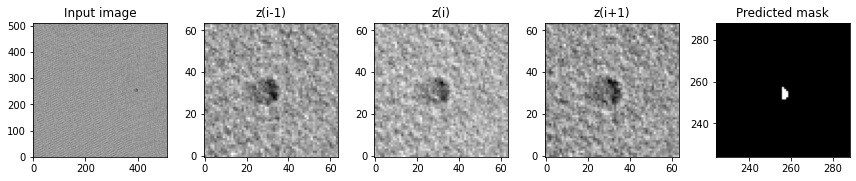

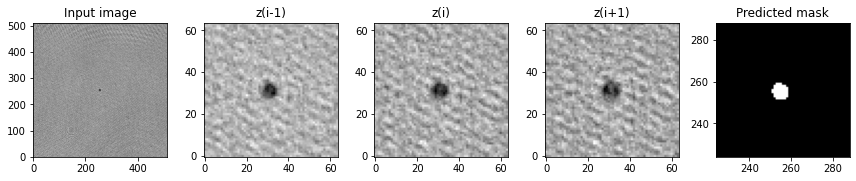

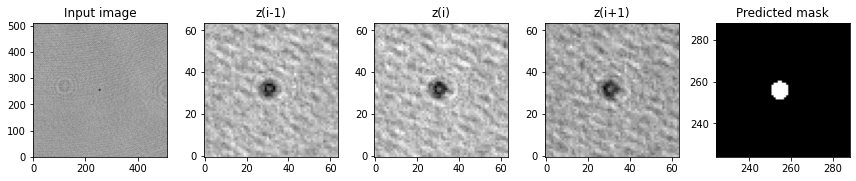

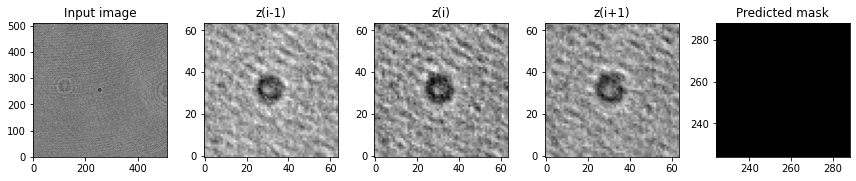

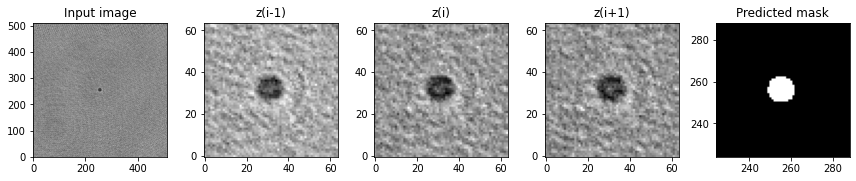

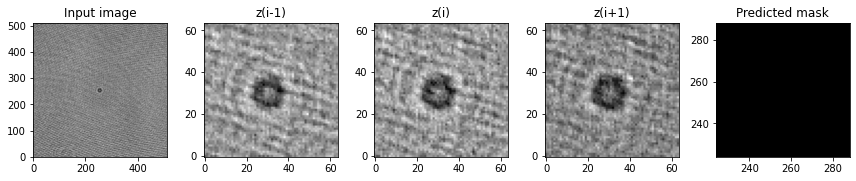

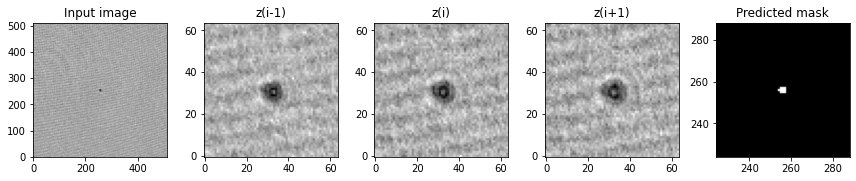

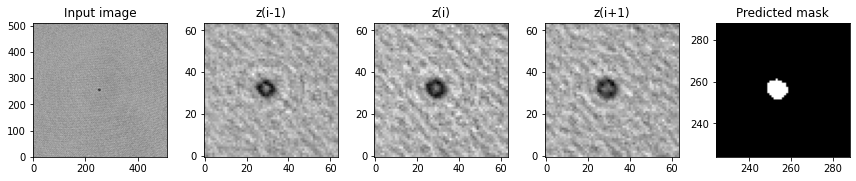

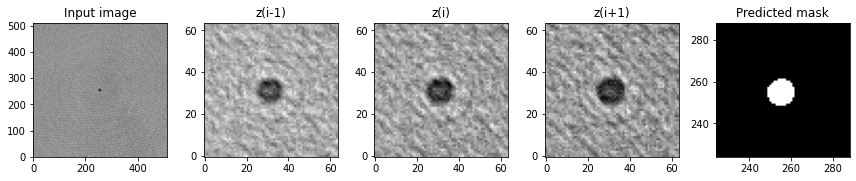

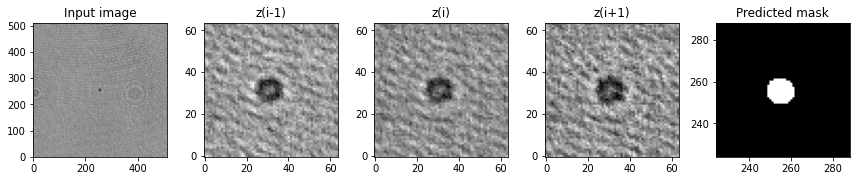

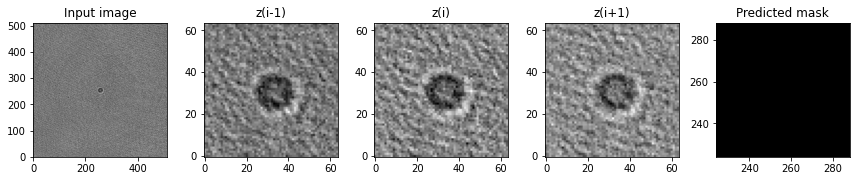

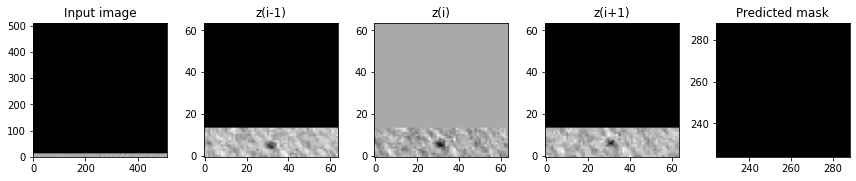

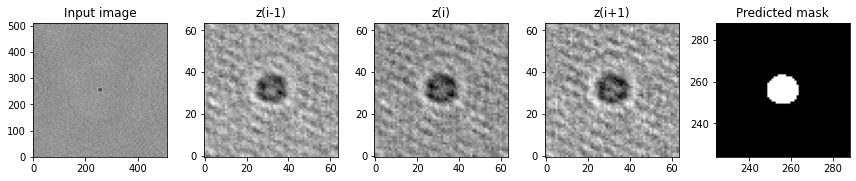

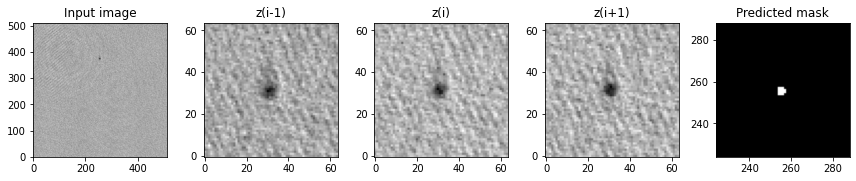

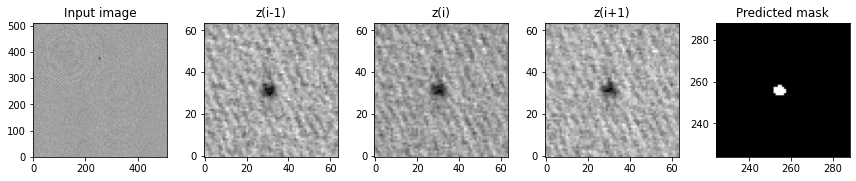

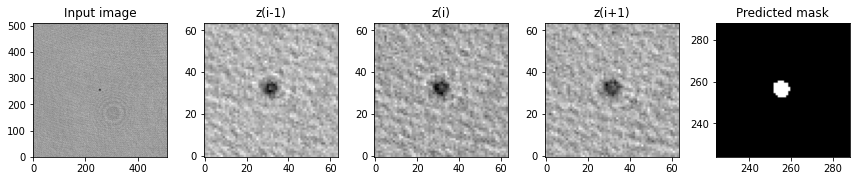

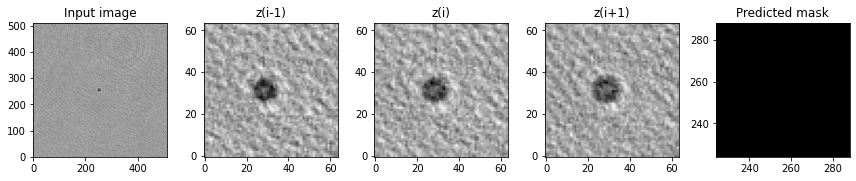

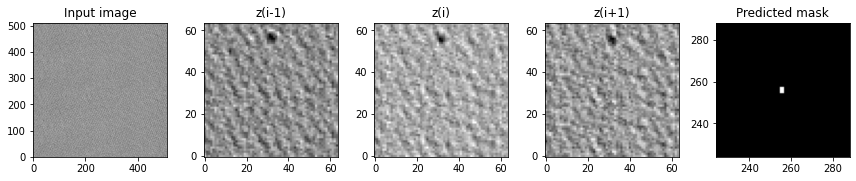

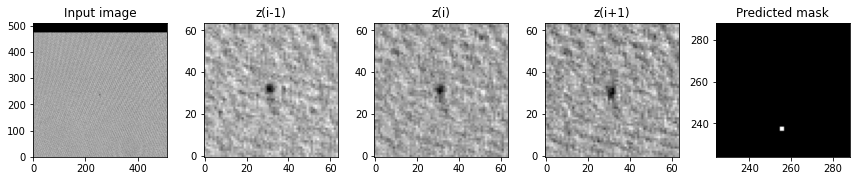

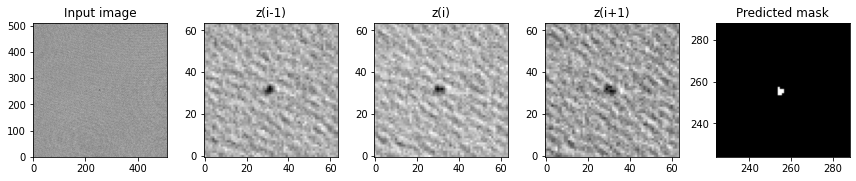

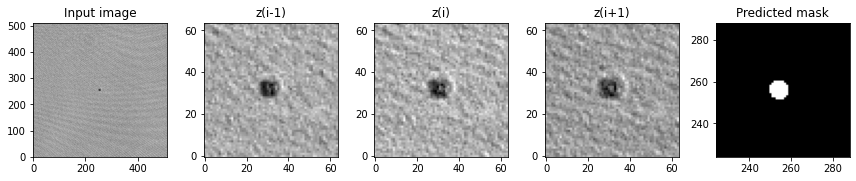

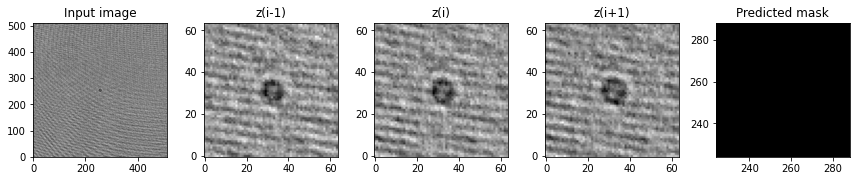

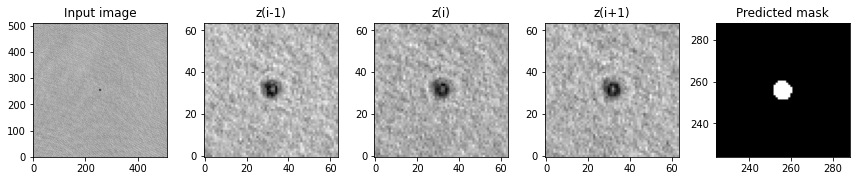

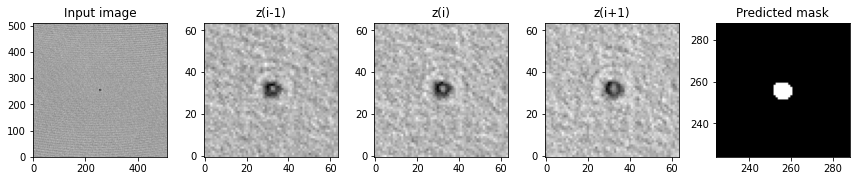

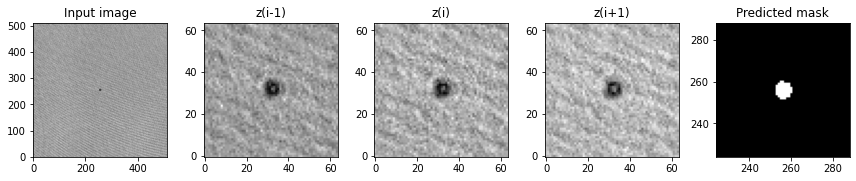

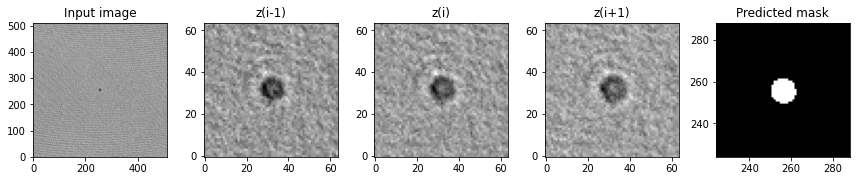

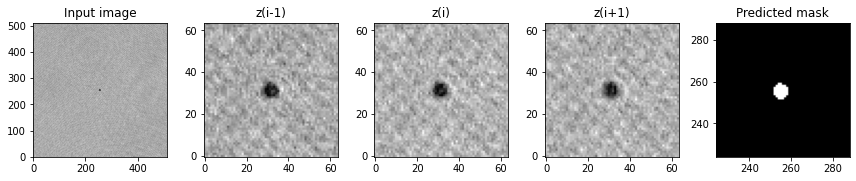

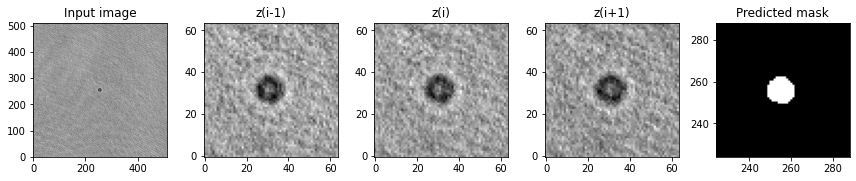

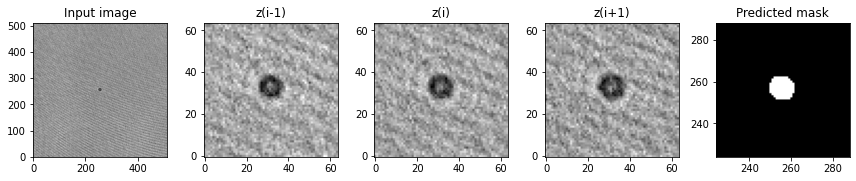

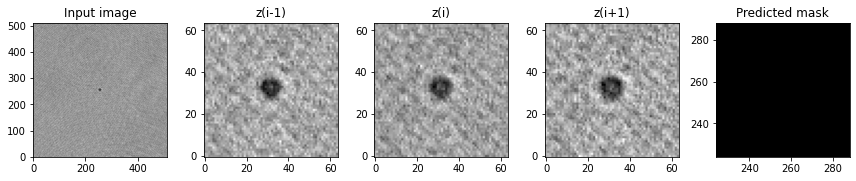

In [15]:
for h_idx in range(11, 12): #20):
    k = 0 
    prop.model.eval()
    real_image = prop.h_ds["image"][h_idx].values
    for (x, y, z, d) in get_particle(prop, h_idx, predicted_particles = table):

        prop_image = propagate(prop, real_image, z)

        dz = prop.z_centers[1] - prop.z_centers[0]
        prop_image_m1 = propagate(prop, real_image, z - dz)
        prop_image_p1 = propagate(prop, real_image, z + dz)

        print(h_idx, x, y, z, d)

        x, y, z = int(x), int(y), int(z)

        ### 512 x 512 image
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=5, sharey='col', figsize=(12,5))

        _x = x if x < 256 else 256
        _y = y if y < 256 else 256

        image = pad(prop_image[(x-_x):(x+_x), (y-_y):(y+_y)].transpose((1,0)), 
            padding = 512,
            fx = _x < 256,
            fy = _y < 256)
        ax1.imshow(image, origin ='lower', cmap = "gray")
        ax1.set_title("Input image")

        X = torch.from_numpy(prop.apply_transforms(prop_image[(x-_x):(x+_x), (y-_y):(y+_y)])).unsqueeze(0).unsqueeze(0)
        with torch.no_grad():
            _, _, a, b = X.shape
            if a != b:
                _X = torch.zeros(1, 1, 512, 512)
                _X[:, :, :a, :b] = X
                X = _X
            mask = (prop.model(X.to(device)).detach().cpu().squeeze(0).squeeze(0).numpy() > 0.5).astype(float)

        ### 32 x 32 image 
        _x = x if x < 32 else 32
        _y = y if y < 32 else 32
        image = pad(prop_image_m1[(x-_x):(x+_x), (y-_y):(y+_y)].transpose((1,0)), 
            padding = 64,
            fx = _x < 32,
            fy = _y < 32)

        ax2.imshow(image, origin ='lower', cmap = "gray")
        ax2.set_title("z(i-1)")

        ### 32 x 32 image 
        _x = x if x < 32 else 32
        _y = y if y < 32 else 32
        image = pad(prop_image[(x-_x):(x+_x), (y-_y):(y+_y)].transpose((1,0)), 
            padding = 64,
            fx = _x < 32,
            fy = _y < 32)

        ax3.imshow(image, origin ='lower', cmap = "gray")
        ax3.set_title("z(i)")

        ### 32 x 32 image 
        _x = x if x < 32 else 32
        _y = y if y < 32 else 32
        image = pad(prop_image_p1[(x-_x):(x+_x), (y-_y):(y+_y)].transpose((1,0)), 
            padding = 64,
            fx = _x < 32,
            fy = _y < 32)

        ax4.imshow(image, origin ='lower', cmap = "gray")
        ax4.set_title("z(i+1)")

        ### Mask prediction
        image = mask.transpose((1,0))
    #     image = pad(image, 
    #         padding = 64,
    #         fx = _x < 32,
    #         fy = _y < 32)
        ax5.imshow(image, origin ='lower', cmap = "gray")
        ax5.set_xlim(256-32, 256+32)
        ax5.set_ylim(256-32, 256+32)
        ax5.set_title("Predicted mask")

        plt.tight_layout()
        #plt.show()

        k += 1
        
        name = f"{h_idx} {int(x)} {int(y)} {int(z)} {np.round(d, 2)}"
        #fig.savefig(f'{path}/labeling/{name}.png', dpi = 300, bbox_inches = "tight")
        fig.show()
        
        #fig.clear()
        #del fig
        #gc.collect()